In [2]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
def concat_ones(data):
    
    size = len(data)
    new_data = np.concatenate((data, np.ones((size, 1))), axis=1)
    
    return new_data

def projection_mse(actual, projected):    
    return np.mean((projected - actual)**2)

def prepare_data():
    
    left_uv = np.load("left_uv_3.npy")
    right_uv = np.load("right_uv_3.npy")
    img_left = plt.imread("Left.jpg")
    img_right = plt.imread("Right.jpg")

    return left_uv, right_uv, img_left, img_right

def normalize_coordinates(left_uv, right_uv):
    
    scaler_left = StandardScaler()
    scaled_left_uv = scaler_left.fit_transform(left_uv)
    scaled_left_uv = concat_ones(scaled_left_uv)

    scaler_right = StandardScaler()
    scaled_right_uv = scaler_right.fit_transform(right_uv)
    scaled_right_uv = concat_ones(scaled_right_uv)
    
    return scaled_left_uv, scaled_right_uv, scaler_right

In [4]:
# Import all inputs
left_uv, right_uv, img_left, img_right = prepare_data()

# Normalise inputs
scaled_left_uv, scaled_right_uv, scaler_right = normalize_coordinates(left_uv, right_uv)

In [5]:
def get_homography_matrix(scaled_right_uv, scaled_left_uv):

    equations = []
    b = []

    for i, ele in enumerate(scaled_left_uv):

        u = scaled_right_uv[i, 0]
        v = scaled_right_uv[i, 1]
        eq1 = np.concatenate(( ele, [0,0,0], -ele*u))[:-1]
        eq2 = np.concatenate(([0,0,0], ele, -ele*v))[:-1]

        equations.append(eq1)
        equations.append(eq2)

        b.append(u)
        b.append(v)


    A, b = np.array(equations), np.array(b)

    H = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.concatenate((H, [1]))
    H = H.reshape((3,3))
    
    return H

H = get_homography_matrix(scaled_right_uv, scaled_left_uv)
H

array([[ 1.01702779,  0.00651686,  0.0929738 ],
       [-0.17311932,  1.01705897, -0.02558022],
       [ 0.09567639, -0.02040539,  1.        ]])

In [6]:
def left_to_right(H, scaled_left_uv, scaler_right):
    
    right_preds = scaled_left_uv @ H
#     right_preds = right_preds[:,:2] / right_preds[:,-1, None]

    right_preds = scaler_right.inverse_transform(right_preds[:,:2])
    
    return right_preds

right_preds = left_to_right(H, scaled_left_uv, scaler_right)

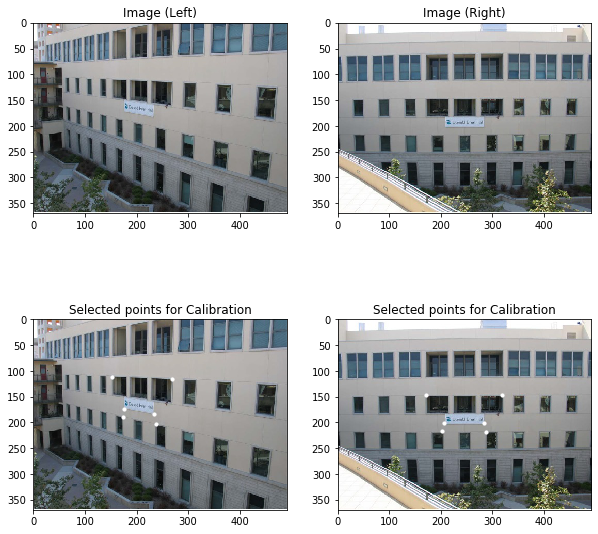

In [7]:
# Show images
fig, ax = plt.subplots(2, 2, figsize=(10,10))

# Show original stereo image
ax[0,0].imshow(img_left)
ax[0,0].set_title("Image (Left)")
# Show original stereo image
ax[0,1].imshow(img_right)
ax[0,1].set_title("Image (Right)")

# Show selected points on input images
ax[1,0].imshow(img_left)
ax[1,0].scatter(left_uv[:,0], left_uv[:,1], s=10, c='w')
ax[1,0].set_title("Selected points for Calibration")

ax[1,1].imshow(img_right)
ax[1,1].scatter(right_uv[:,0], right_uv[:,1], s=10, c='w')
ax[1,1].set_title("Selected points for Calibration")

plt.show()

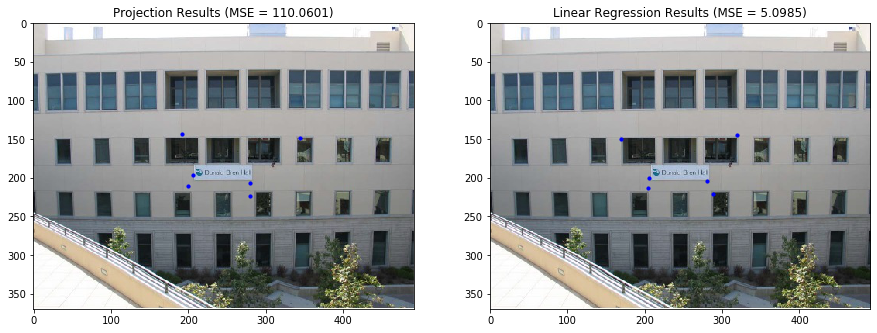

In [8]:
# Show images
fig, ax = plt.subplots(1,2, figsize=(15,12))

ax[0].imshow(img_right)
ax[0].scatter(right_preds[:,0], right_preds[:,1], s=10, c='b')
ax[0].set_title("Projection Results (MSE = %.4f)"%projection_mse(right_uv, right_preds))

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(scaled_left_uv, scaled_right_uv)

linreg_right_preds = model.predict(scaled_left_uv)
linreg_right_preds = scaler_right.inverse_transform(linreg_right_preds[:,:2])

ax[1].imshow(img_right)
ax[1].scatter(linreg_right_preds[:,0], linreg_right_preds[:,1], s=10, c='b')
ax[1].set_title("Linear Regression Results (MSE = %.4f)"%projection_mse(right_uv, linreg_right_preds))

plt.show()

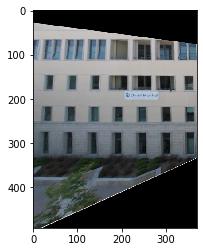

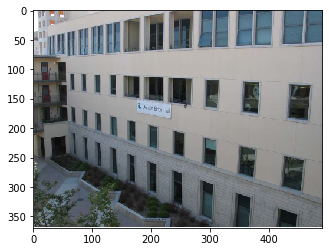

In [9]:
h, status = cv2.findHomography(left_uv, right_uv)
im_dst = cv2.warpPerspective(img_left, h, img_left.shape[:2])
plt.imshow(im_dst)
plt.show()

plt.imshow(img_left)
plt.show()

In [10]:
h, H

(array([[ 3.11819134e+00, -2.04754103e-01, -1.99325186e+02],
        [ 5.17200291e-01,  1.23507623e+00,  2.44039761e+00],
        [ 3.83990059e-03, -8.93766998e-04,  1.00000000e+00]]),
 array([[ 1.01702779,  0.00651686,  0.0929738 ],
        [-0.17311932,  1.01705897, -0.02558022],
        [ 0.09567639, -0.02040539,  1.        ]]))